Soroush Famili, James Lu, Nithanth Ram

# Lab 9

This lab contains a number of different goals and ideas. The first part is low-level, and intended
to get you playing directly with pytorch. The middle part introduces you to the fascinating world of
Adversarial Attacks, but also gives practice with the important idea that you the power of torch (or
tensorflow) is that they allow you to compute derivatives of various kinds, and these can be used
for various interesting applications. Finally, the third part introduces you to powerful highlevel
tools built on top of pytorch. I hope that all of these ideas will be interesting, and also potentially
interesting and useful for your final projects.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.signal import correlate

# Problem 1: Convolutions

#### 1. Compute the output of a 1D convolution layer if the input is a single-channel vector [1,-1,3,4,4] and the kernal is [1,1] for stride =1 and padding =0.


In [2]:
x1 = [1, -1, 3, 4, 4]
kernel1 = [1, 1]

output = correlate(x1, kernel1, mode="valid")

print(output)

C:\Users\sorou\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


[0 2 7 8]


### 2. Compute the output of a 1D convolution layer if the input is a single-channel vector [1,-1,3,4,4] and the kernal is [1,-1] for stride =1 and padding =1 (padding one means on both sides)


In [3]:
x2 = [0, 1, -1, 3, 4, 4, 0]
kernel2 = [1, -1]

output = correlate(x2, kernel2, mode="valid")

print(output)

[-1  2 -4 -1  0  4]


### 3.Write pytorch code that computes these outputs. Create the corresponding tensors and use torch.nn.Conv1d and ConvTranspose1d.

In [4]:
x_tensor = torch.tensor([[[1, -1, 3, 4, 4]]])
kernel1_tensor = torch.tensor([[[1, 1]]])
kernel2_tensor = torch.tensor([[[1, -1]]])

conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)
conv1.weight.data = kernel1_tensor
y1 = conv1(x_tensor)

conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=1, bias=False)
conv2.weight.data = kernel2_tensor
y2 = conv2(x_tensor)

print(f"Kernel={kernel1}, Padding=0, Convolution={y1}")
print(f"Kernel={kernel2}, Padding=1, Convolution={y2}")

Kernel=[1, 1], Padding=0, Convolution=tensor([[[0, 2, 7, 8]]], grad_fn=<SqueezeBackward1>)
Kernel=[1, -1], Padding=1, Convolution=tensor([[[-1,  2, -4, -1,  0,  4]]], grad_fn=<SqueezeBackward1>)


# Problem 2: Training a CIFAR-10 CNN classifier

In this problem we will follow a tutorial to build a Convolutional neural network that classifies
images from the CIFAR-10 dataset and then modify it.

## 1. Start by implementing and running this tutorial. https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/ Show the accuracy you get and also the confusion matrix you obtain for the 10 classes.

In [5]:
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

In [6]:
trainset = torchvision.datasets.CIFAR10(root='/home/CIFAR-10 Classifier Using CNN in PyTorch/data/',
                                       train=True,
                                       download=True,
                                       transform=transform)


Files already downloaded and verified


In [7]:
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=4,
                                         shuffle=True)

In [8]:
testset = torchvision.datasets.CIFAR10(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)

Files already downloaded and verified


In [9]:
testloader = torch.utils.data.DataLoader(testset,
                                        batch_size=4,
                                        shuffle=False)

In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
def convert_to_imshow_format(image):
    image = image/2 + .5
    image = image.numpy()
    
    return image.transpose(1,2,0)

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

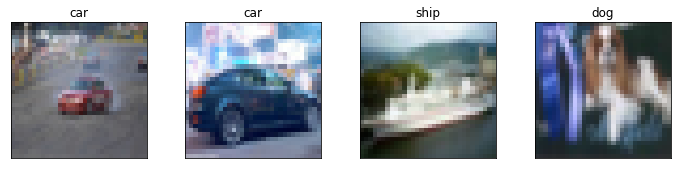

In [13]:
fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [19]:
net = Net()

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
model_directory_path = '/home/CIFAR-10 Classifier Using CNN in PyTorch/model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'
start_time = time.time()
if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    net.load_state_dict(torch.load(model_path))
    print('Loaded model parameters from disk.')
else:
    for epoch in range(2):
        
        running_loss = 0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i%2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                
        print('Finished Training.')
        torch.save(net.state_dict(), model_path)
        print('Saved model parameters to disk.')
        print(f"{(time.time() - start_time)/60} minutes")

[1,  2000] loss: 1.484
[1,  4000] loss: 1.456
[1,  6000] loss: 1.415
[1,  8000] loss: 1.374
[1, 10000] loss: 1.331
[1, 12000] loss: 1.334
Finished Training.
Saved model parameters to disk.
1.0703129490216574 minutes
[2,  2000] loss: 1.246
[2,  4000] loss: 1.260
[2,  6000] loss: 1.226
[2,  8000] loss: 1.224
[2, 10000] loss: 1.221
[2, 12000] loss: 1.200
Finished Training.
Saved model parameters to disk.
2.176396210988363 minutes


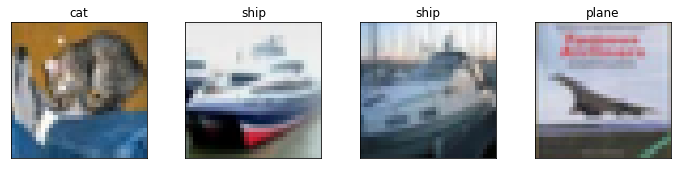

In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [27]:
ouputs = net(images)
ouputs

tensor([[-1.5323, -0.5190, -0.1358,  2.6334, -1.5633,  0.9227,  0.7531, -1.4117,
          0.1951, -0.3671],
        [ 3.1693,  7.0781, -1.7298, -2.5357, -4.1271, -4.5405, -2.6408, -4.4076,
          5.9771,  2.0336],
        [ 1.4319,  3.4355, -0.0187, -1.1455, -2.3461, -2.1212, -1.5740, -2.1208,
          0.7363,  2.5467],
        [ 4.2276,  0.4104,  1.3499, -1.5709, -0.2744, -3.4300, -2.3741, -2.6106,
          4.8709,  0.0503]], grad_fn=<AddmmBackward>)

In [29]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
sm_outputs

tensor([[9.5081e-04, 2.9556e-04, 9.2595e-03, 4.2859e-04, 1.7560e-02, 5.2637e-03,
         6.2888e-04, 9.6492e-01, 2.7667e-06, 6.8870e-04],
        [8.7572e-02, 3.3346e-02, 3.0474e-03, 1.6391e-03, 1.7031e-03, 9.3738e-05,
         1.2799e-03, 5.2412e-05, 8.6865e-01, 2.6191e-03],
        [2.5298e-02, 9.2315e-01, 3.2658e-03, 1.4599e-03, 3.1706e-03, 4.6434e-04,
         4.6992e-03, 3.2077e-04, 2.1973e-02, 1.6202e-02],
        [7.8214e-02, 2.7807e-02, 5.9540e-02, 9.7410e-02, 3.9375e-02, 2.2827e-02,
         6.6139e-02, 1.7674e-02, 3.6679e-01, 2.2423e-01]],
       grad_fn=<SoftmaxBackward>)

In [30]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

horse - 0.9649
ship - 0.8686
car - 0.9231
ship - 0.3668


In [31]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 56.75%


In [32]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 65.2
car        - 83.7
bird       - 43.2
cat        - 34.0
deer       - 62.8
dog        - 43.5
frog       - 46.7
horse      - 66.7
ship       - 60.5
truck      - 61.2


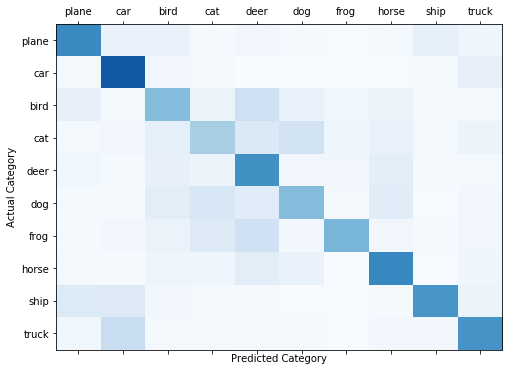

In [33]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [34]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           652       68        69        15        33        10        5         18        86        44        
                0.652     0.068     0.069     0.015     0.033     0.01      0.005     0.018     0.086     0.044     
car             18        837       24        12        3         3         6         5         13        79        
                0.018     0.837     0.024     0.012     0.003     0.003     0.006     0.005     0.013     0.079     
bird            79        23        432       58        206       69        39        55        21        18        
                0.079     0.023     0.432     0.058     0.206     0.069     0.039     0.055     0.021     0.018     
cat             21        33        92        340       138       190       45        74        16        51        
                0.021     0.033     0.092     0.34      0.138   

## 2. Show the convolutional layer kernels you learned in the first convolutional layer.

In [45]:
def plot_kernels(tensor, num_cols=6):
    num_rows = 1
    fig = plt.figure(figsize=(num_cols, num_rows))
    i = 0
    for t in tensor:
        ax1 = fig.add_subplot(num_rows, num_cols, i+1)
        pilTrans = transforms.ToPILImage()
        pilImg = pilTrans(t)
        ax1.imshow(pilImg, interpolation='none')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        i += 1
    
    plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.show()

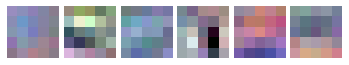

In [48]:
kernels = net.conv1.weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels/kernels.max()
plot_kernels(kernels)